# **A. Import Libraries**

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import colorsys
from PIL import Image

import os
import glob
from pathlib import Path
import plotly.graph_objects as go

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# !pip install -q jmd_imagescraper
from jmd_imagescraper.core import *

# **B. Data Loading**

At this stage, loading data is carried out and creating a dataframe from the results of loading the data

In [2]:
dataGen = ImageDataGenerator()

data = dataGen.flow_from_directory(
	"C:/Users/Muhammad Hafidz Adit.DESKTOP-6IPGJGG/Documents/Hacktiv8/P2/GC7/GestureImageData",
	target_size=(50,50),
	class_mode='categorical',
    batch_size=32
)

Found 55500 images belonging to 37 classes.


In [3]:
# Dictionary untuk menyimpan hasil glob.glob() berdasarkan label
files_dict = {}

# List label
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
          'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
          'U', 'V', 'W', 'X', 'Y', 'Z', '_']

# Loop untuk mengisi dictionary
for label in labels:
    # Mendapatkan file berdasarkan label menggunakan glob.glob()
    files_dict[label] = glob.glob(f'C:/Users/Muhammad Hafidz Adit.DESKTOP-6IPGJGG/Documents/Hacktiv8/P2/GC7/GestureImageData/{label}/*')

# Membuat DataFrame dari dictionary
img_df = pd.DataFrame({'images': sum(files_dict.values(), []), 'label': sum(([k] * len(v) for k, v in files_dict.items()), [])})
img_df = img_df.sample(len(img_df)).reset_index(drop=True)


# Menampilkan DataFrame
img_df.head()

,images,label
0,C:/Users/Muhammad Hafidz Adit.DESKTOP-6IPGJGG/...,E
1,C:/Users/Muhammad Hafidz Adit.DESKTOP-6IPGJGG/...,K
2,C:/Users/Muhammad Hafidz Adit.DESKTOP-6IPGJGG/...,A
3,C:/Users/Muhammad Hafidz Adit.DESKTOP-6IPGJGG/...,8
4,C:/Users/Muhammad Hafidz Adit.DESKTOP-6IPGJGG/...,A


In [4]:
img_df.shape

(55500, 2)

In [5]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  55500 non-null  object
 1   label   55500 non-null  object
dtypes: object(2)
memory usage: 867.3+ KB


- there are 55500 images data with 37 classes.
- create a Dataframe with 55500 data results and 2 columns with object type

# **C. Exploratory Data Analysis (EDA)**

## **1. Distribusi Label**

In [4]:
# Get value counts of labels and sort by index
label_counts = img_df['label'].value_counts().sort_index()

# Number of colors needed
num_colors = len(label_counts)

# Generate equally spaced hues
hues = [i / num_colors for i in range(num_colors)]

# Convert hues to RGB colors
colors_rgb = [colorsys.hsv_to_rgb(hue, 1, 1) for hue in hues]

# Convert RGB colors to Plotly-compatible format
colors_plotly = ['rgb({}, {}, {})'.format(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in colors_rgb]

# Create subplot grid
fig = go.Figure()

# Create bar chart trace with the specified colors
bar_chart = go.Bar(x=label_counts.index, 
                   y=label_counts.values,
                   marker=dict(color=colors_plotly),  # Assign colors to bars
                   name='Label Counts')       # Name for legend

# Add trace to subplot grid
fig.add_trace(bar_chart)

# Update layout to display legend
fig.update_layout(legend=dict(x=0, y=1, traceorder='normal', font=dict(family='sans-serif', size=12, color='black')))

# Display the figure
fig.show()


Insights:
- There are 37 classes for sign language movements represented in a bar chart.
- All classes have the same amount of data, namely 1500.
- Even data distribution among all classes.

## **2. Displays an Image of Each Label**

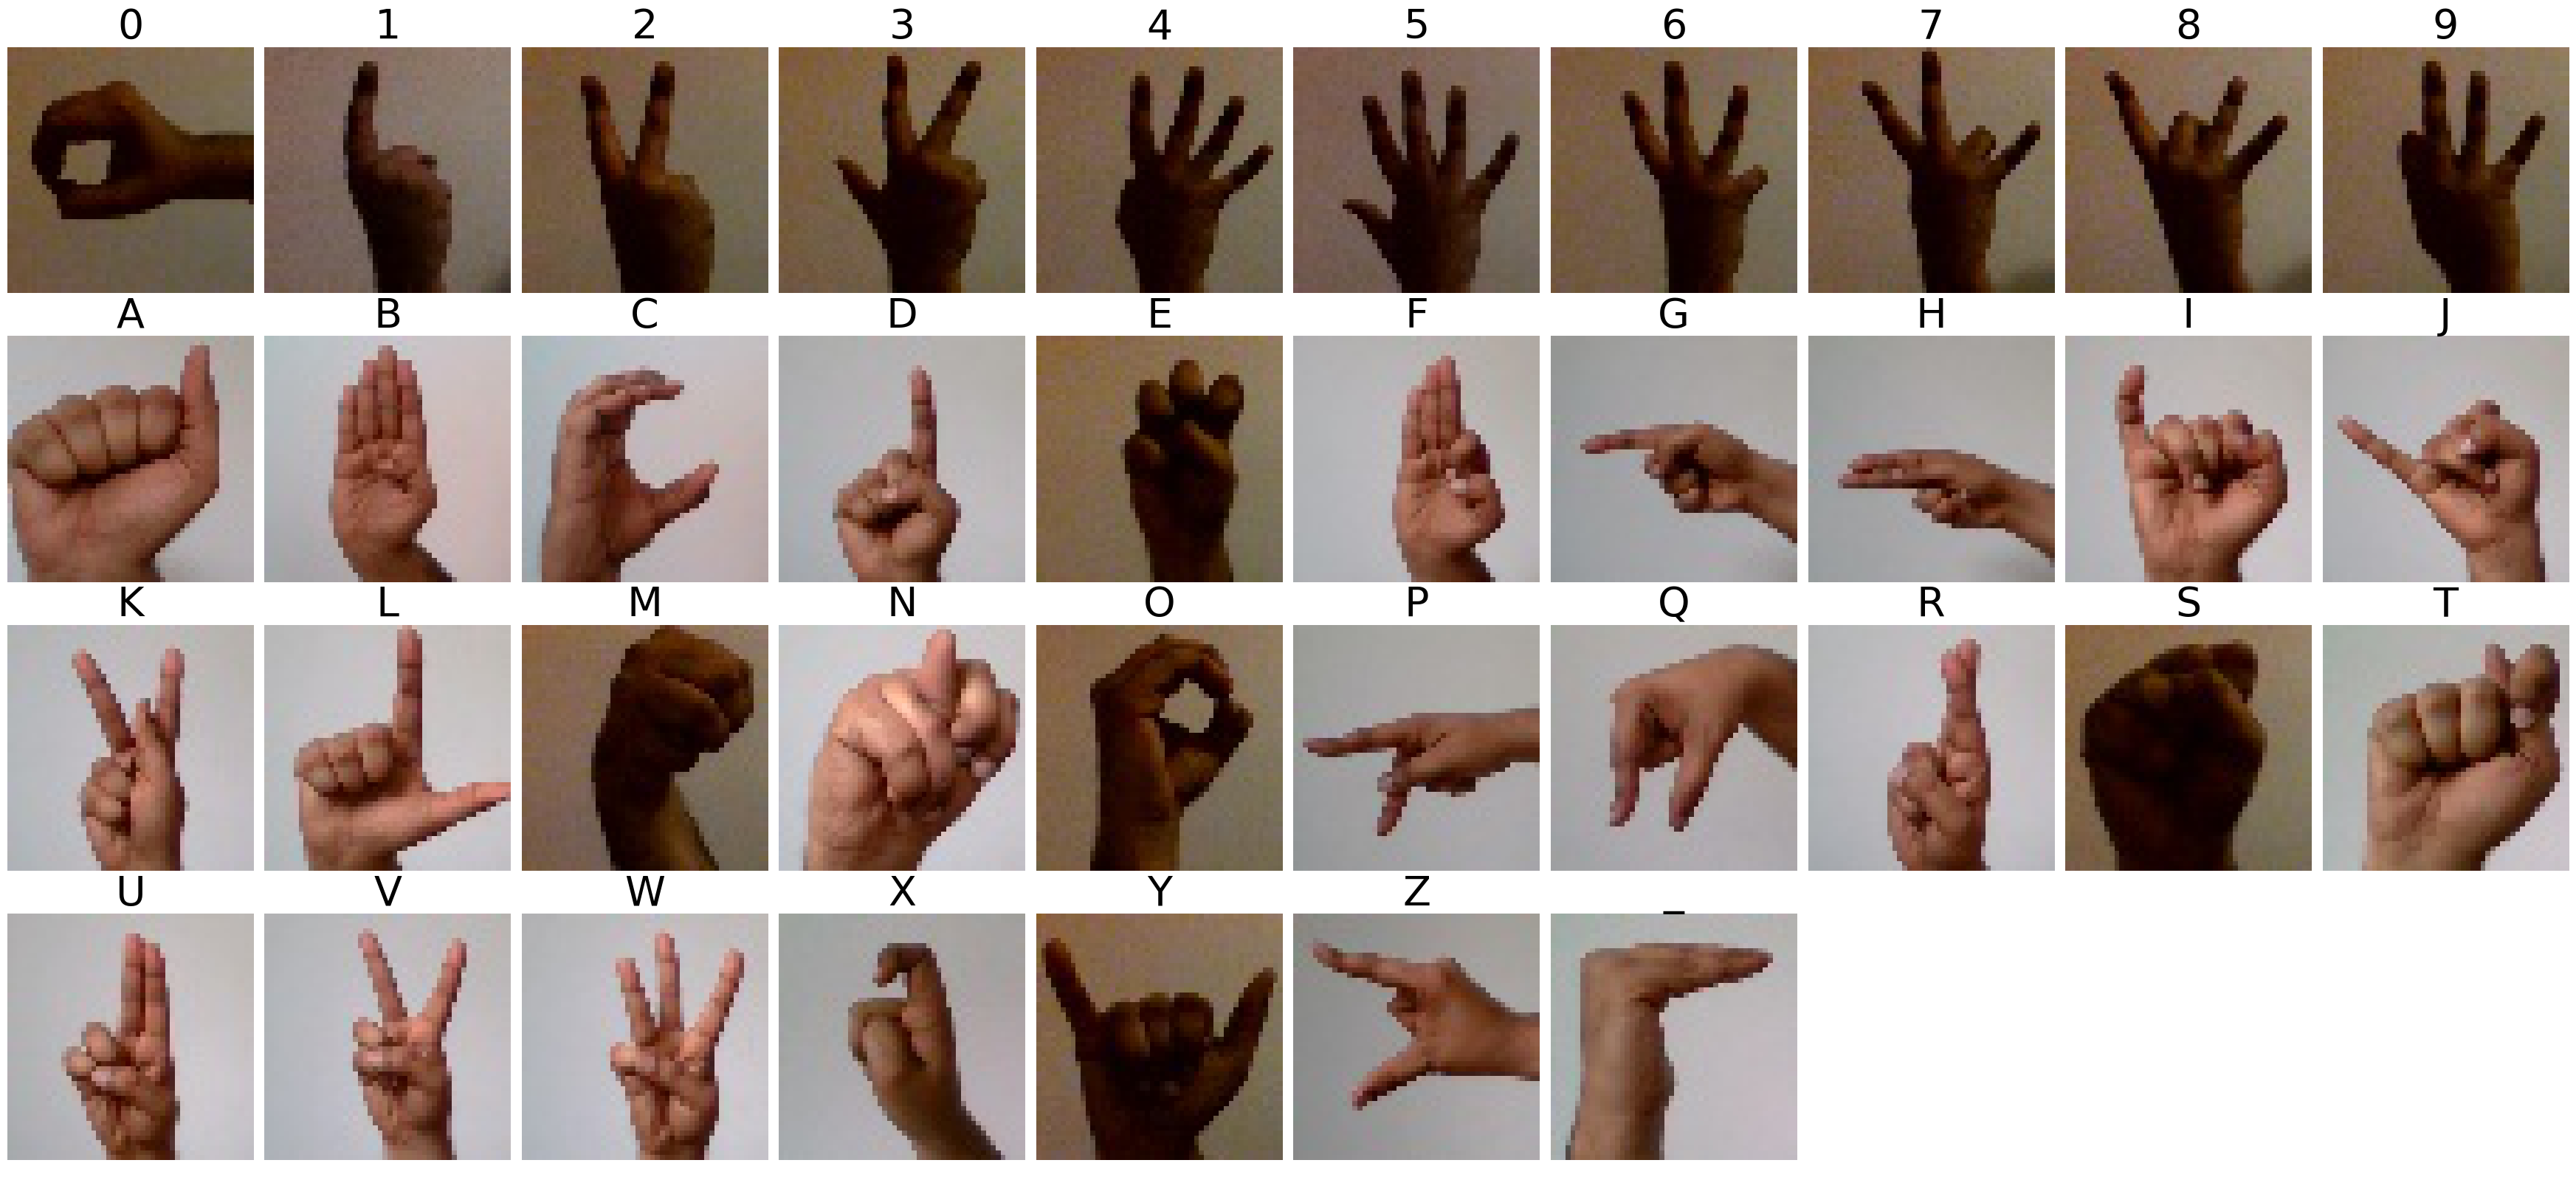

In [132]:
# Sort DataFrame by label
sorted_df = img_df.sort_values(by='label')

# Group DataFrame by label and select the first image from each group
unique_images_df = sorted_df.groupby('label').first().reset_index()

# Create subplots
num_labels = len(unique_images_df)
num_cols = 10  # Assuming 5 columns for display
num_rows = (num_labels + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(35, num_rows * 4))

# Loop through unique images and plot
for i, (_, row) in enumerate(unique_images_df.iterrows()):
    img_path = row['images']  # Assuming 'image_path' contains file paths to the images
    label = row['label']
    img = Image.open(img_path)
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(img)
    ax.set_title(label)
    ax.set_title(label, fontsize=40)  # Increase font size to 14 (adjust size as needed)
    ax.axis('off')

# Hide empty subplots
for i in range(num_labels, num_rows * num_cols):
    axes.flatten()[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


Insight :
- Displays images of each class

# **D. Feature Engineering**

At this stage the data will be split. The data will be divided into 2 parts, namely train and validation (val). At this stage, data augmentation was not carried out because I think sign language gestures may have a specific meaning and are important to convey clearly. Significantly altering these images through data augmentation can obscure the meaning of the original gesture, making interpretation and communication difficult.

## **1 Split Train & Val**

In [5]:
path = 'C:/Users/Muhammad Hafidz Adit.DESKTOP-6IPGJGG/Documents/Hacktiv8/P2/GC7/GestureImageData/'

imgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        validation_split=0.4)
train = imgen.flow_from_directory(path,
                                    target_size=(50,50),
                                    class_mode='categorical',
                                    subset='training',
                                    shuffle=True,
                                    seed=2)

val = imgen.flow_from_directory(path,
                                  target_size=(50,50),
                                  class_mode='categorical',
                                  subset='validation',
                                  shuffle=True,
                                  seed=2)


Found 33300 images belonging to 37 classes.
Found 22200 images belonging to 37 classes.


In [6]:
train.image_shape

(50, 50, 3)

In [7]:
print(train.class_indices)
print(val.class_indices)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, '_': 36}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, '_': 36}


c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



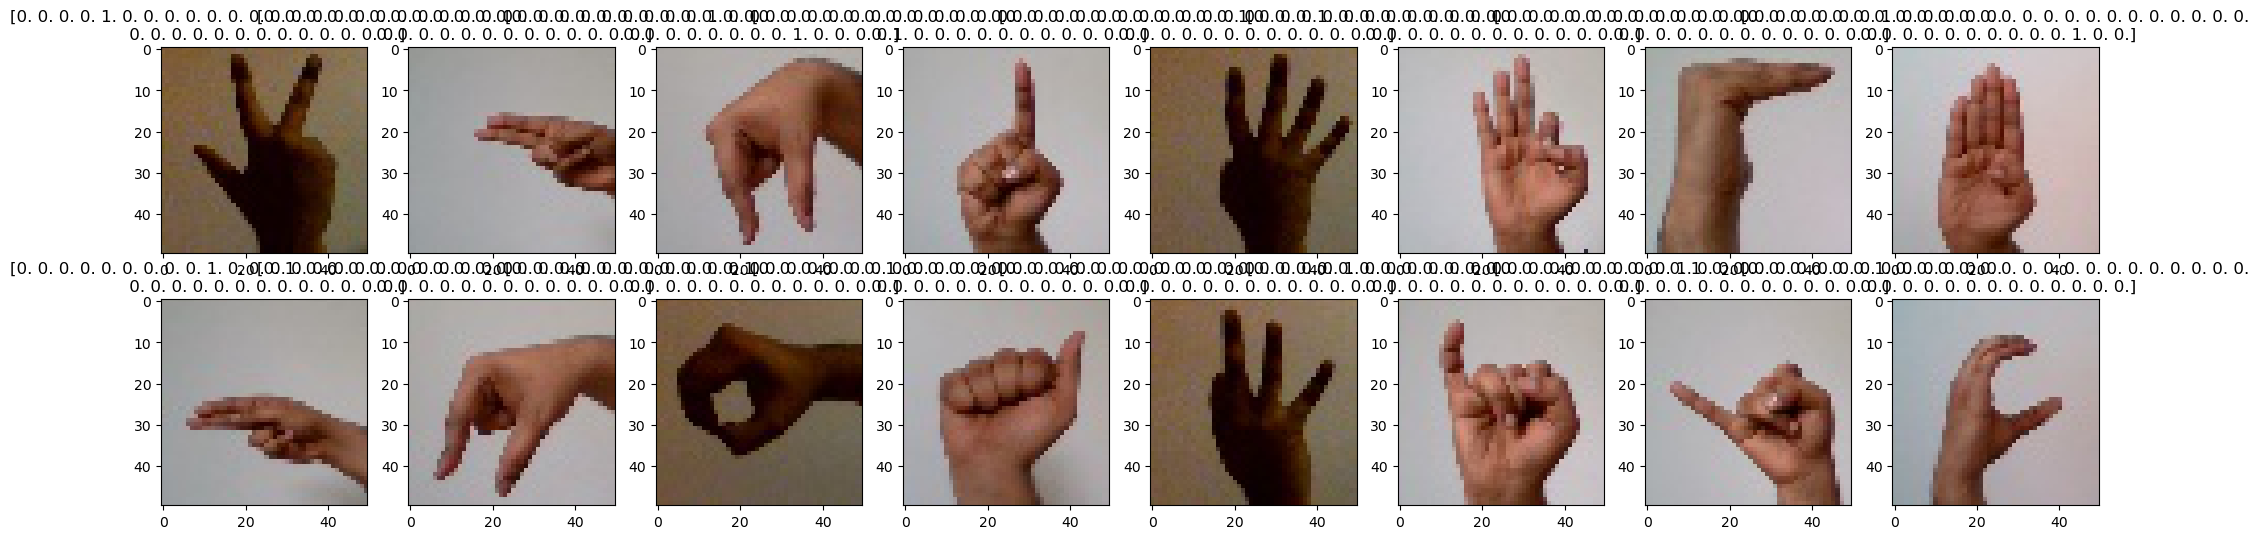

In [8]:
fig,ax = plt.subplots(nrows=2,ncols=8,figsize=(25,6))
n = 0
idx = np.random.randint(len(train.next()[0]), size=16)
for i in range(2):
  for j in range(8):
    img = train.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(train.next()[1][idx[n]])
    n+=1

Conclusion :
- At this stage, the train and val data are split
- In the train data there are 33300 images with 37 classes.
- In the val data there are 22200 images with 37 classes.
- The image has a size of 50 x 50

# **E. ANN Training**

At this stage, the Sequential API and Functional API models are defined. By creating 2 convolutional layers and 3 hidden later with relu activation, and at the output using softmax because the desired results are categorical

## **1. Sequential API**

### 1.1. Model Definition

In [45]:
# Create Sequential API
model_ann_sequential = tf.keras.models.Sequential()

# Convolutional Layer
model_ann_sequential.add(tf.keras.layers.Conv2D(32, (3,3), strides=(1, 1), padding='valid', activation='relu', input_shape=(50, 50, 3), name ='conv-layer1'))
model_ann_sequential.add(tf.keras.layers.MaxPooling2D(2, 2))
model_ann_sequential.add(tf.keras.layers.Conv2D(64, (3,3), strides=(1, 1), padding='valid', activation='relu', name ='conv-layer2'))
model_ann_sequential.add(tf.keras.layers.MaxPooling2D(2, 2))

# hidden layer
model_ann_sequential.add(tf.keras.layers.Flatten(name = 'flatten'))
model_ann_sequential.add(tf.keras.layers.Dense(512, activation='relu', name = 'hidden-layer1'))
model_ann_sequential.add(tf.keras.layers.Dense(256, activation='relu', name = 'hidden-layer2'))
model_ann_sequential.add(tf.keras.layers.Dense(128, activation='relu', name = 'hidden-layer3'))
model_ann_sequential.add(tf.keras.layers.Dense(37, activation='softmax', name = 'output'))

# Compile
model_ann_sequential.compile(loss = 'categorical_crossentropy', 
                            optimizer='Adam', 
                            metrics=['accuracy'])

# mencetak ringkasan struktur dan konfigurasi model
model_ann_sequential.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv-layer1 (Conv2D)        (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv-layer2 (Conv2D)        (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 hidden-layer1 (Dense)       (None, 512)             

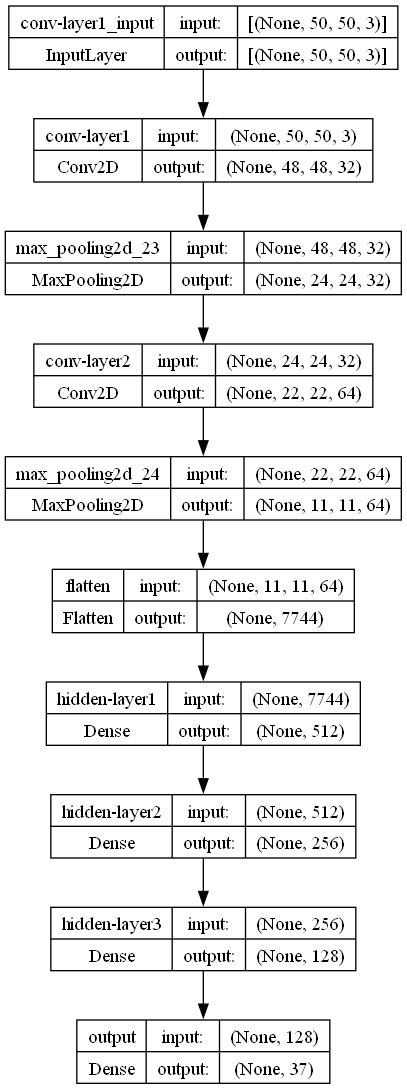

In [46]:
# Plot Layers

tf.keras.utils.plot_model(model_ann_sequential,show_shapes=True)

### 1.2. Model Training

In [49]:
# Melakukan training data
history_1= model_ann_sequential.fit(train, batch_size=32, validation_data=(val), epochs=25)

Epoch 1/25
1041/1041 [==============================] - 213s 204ms/step - loss: 0.0188 - accuracy: 0.9948 - val_loss: 0.3173 - val_accuracy: 0.9364
Epoch 2/25
1041/1041 [==============================] - 178s 171ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.3023 - val_accuracy: 0.9536
Epoch 3/25
1041/1041 [==============================] - 150s 144ms/step - loss: 1.3763e-05 - accuracy: 1.0000 - val_loss: 0.2956 - val_accuracy: 0.9550
Epoch 4/25
1041/1041 [==============================] - 143s 138ms/step - loss: 2.9313e-06 - accuracy: 1.0000 - val_loss: 0.3203 - val_accuracy: 0.9555
Epoch 5/25
1041/1041 [==============================] - 147s 142ms/step - loss: 1.0434e-06 - accuracy: 1.0000 - val_loss: 0.3348 - val_accuracy: 0.9555
Epoch 6/25
1041/1041 [==============================] - 124s 119ms/step - loss: 5.5750e-07 - accuracy: 1.0000 - val_loss: 0.3405 - val_accuracy: 0.9555
Epoch 7/25
1041/1041 [==============================] - 140s 135ms/step - loss: 3.2802e-07 - acc

### 1.3. Model Evaluation

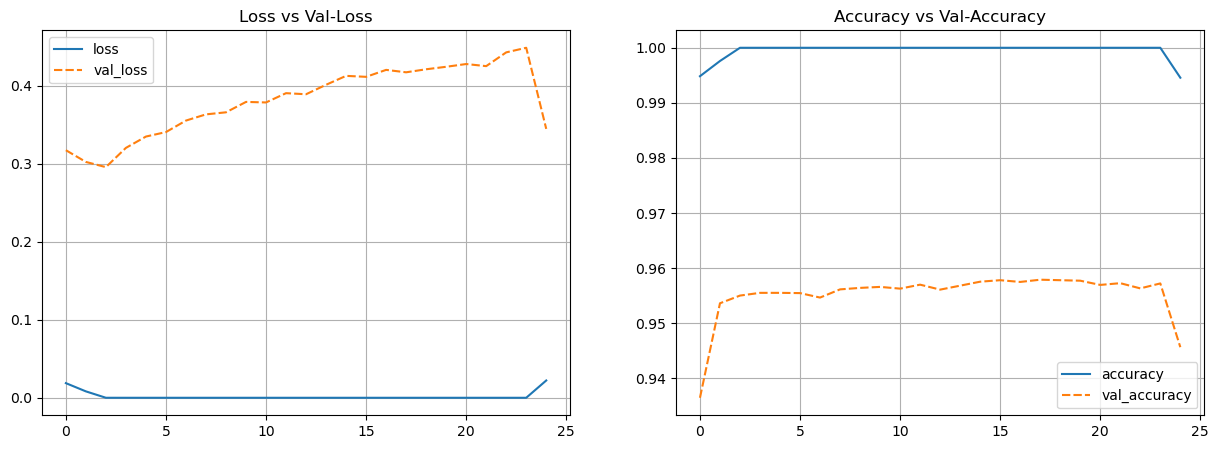

In [50]:
# Plot Training Results
history_1_df= pd.DataFrame(history_1.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_1_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_1_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [52]:
results_train= model_ann_sequential.evaluate(train, verbose=0)
print('train_acc', results_train[1])
print('train_loss', results_train[0])

train_acc 0.9986486434936523
train_loss 0.004921725019812584


In [54]:
results_val= model_ann_sequential.evaluate(val, verbose=0)
print('val_acc', results_val[1])
print('val_loss', results_val[0])

val_acc 0.9456306099891663
val_loss 0.34463950991630554


Conclusion :
1. Model Performance:

    - Training Accuracy: 0.9986 (99.86%) - indicates the model performs very well on the training data, almost classifying all examples perfectly.
    - Training Loss: 0.0049 - this is a very low loss value, indicating the model has learned the training data well.
    - Validation Accuracy: 0.9456 (94.56%) - this is still good accuracy, but much lower than training accuracy, indicating potential for overfitting.
    - Validation Loss: 0.3446 - this is a higher loss value than the training loss, which further indicates overfitting.

2. The model appears to be overfitting the training data. Although it performs very well on the training set, its generalization to unseen data (represented by the validation set) is not so good.

## **2. Functional API**

### 2.1. Model Definition

In [64]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Model menggunakan Functional API
input_layer = Input(shape=(50, 50, 3), name='input')

# Menambahkan Convolutional Layer
conv_layer1 = Conv2D(32, (3,3), strides=(1, 1), padding='valid', activation='relu')(input_layer)
maxpool_layer1 = MaxPooling2D(2, 2)(conv_layer1)
conv_layer2 = Conv2D(64, (3,3), strides=(1, 1), padding='valid', activation='relu')(maxpool_layer1)
maxpool_layer2 = MaxPooling2D(2, 2)(conv_layer2)

# Layer-layer Dense setelah lapisan konvolusi
hidden_layer1 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed), name='hidden_layer1')(maxpool_layer2)
hidden_layer2 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed), name='hidden_layer2')(hidden_layer1)
hidden_layer3 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed), name='hidden_layer3')(hidden_layer2)

# Menggabungkan hasil dari lapisan Dense
concat = Concatenate(name='concat')([hidden_layer1, hidden_layer3])
flatten = Flatten()(concat)

# Output layer
output_layer = Dense(37, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed), name='output')(flatten)

# Membuat model
model_functional = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile
# optimizer= tf.keras.optimizers.Adam(learning_rate=0.01)

model_functional.compile(loss='categorical_crossentropy',
                         optimizer='Adam',
                         metrics=['accuracy'])

# mencetak ringkasan struktur dan konfigurasi model
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           896       ['input[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 22, 22, 64)           18496     ['max_pooling2d[0][0]']   

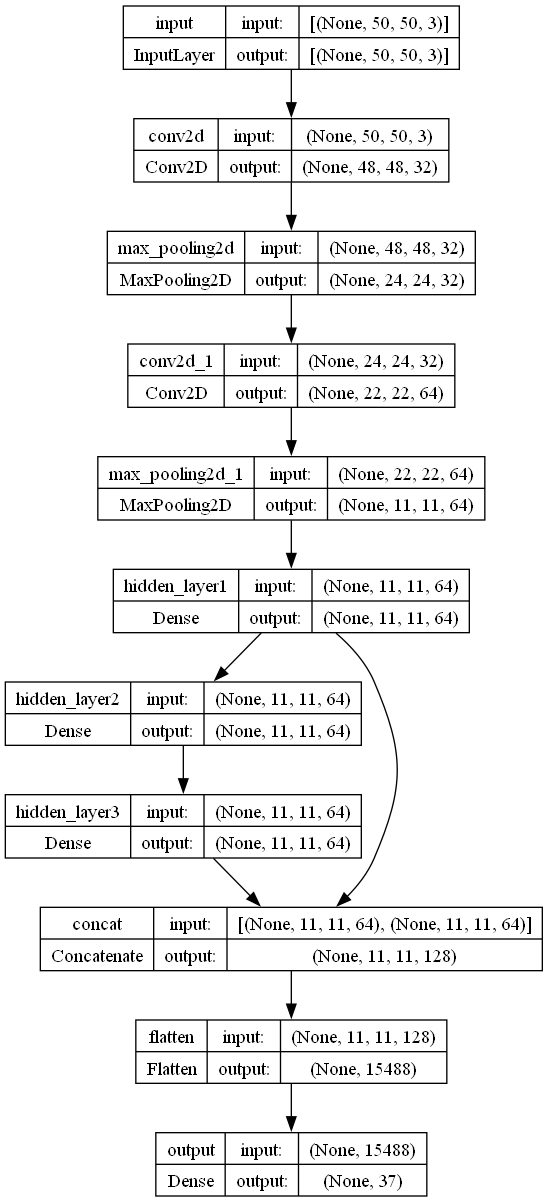

In [65]:
# Plot Layers

tf.keras.utils.plot_model(model_functional,show_shapes=True)

### 2.2. Model Training

In [66]:
# Melakukan training data
history_2= model_functional.fit(train, batch_size=32, validation_data=(val), epochs=25)

Epoch 1/25
1041/1041 [==============================] - 66s 62ms/step - loss: 0.1329 - accuracy: 0.9623 - val_loss: 0.2498 - val_accuracy: 0.9522
Epoch 2/25
1041/1041 [==============================] - 62s 59ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.2705 - val_accuracy: 0.9563
Epoch 3/25
1041/1041 [==============================] - 59s 56ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.3343 - val_accuracy: 0.9331
Epoch 4/25
1041/1041 [==============================] - 52s 50ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.2374 - val_accuracy: 0.9587
Epoch 5/25
1041/1041 [==============================] - 55s 53ms/step - loss: 9.2686e-06 - accuracy: 1.0000 - val_loss: 0.2506 - val_accuracy: 0.9577
Epoch 6/25
1041/1041 [==============================] - 59s 56ms/step - loss: 4.2313e-06 - accuracy: 1.0000 - val_loss: 0.2599 - val_accuracy: 0.9577
Epoch 7/25
1041/1041 [==============================] - 59s 57ms/step - loss: 2.3185e-06 - accuracy: 1.0000 - val_lo

### 2.3. Model Evaluation

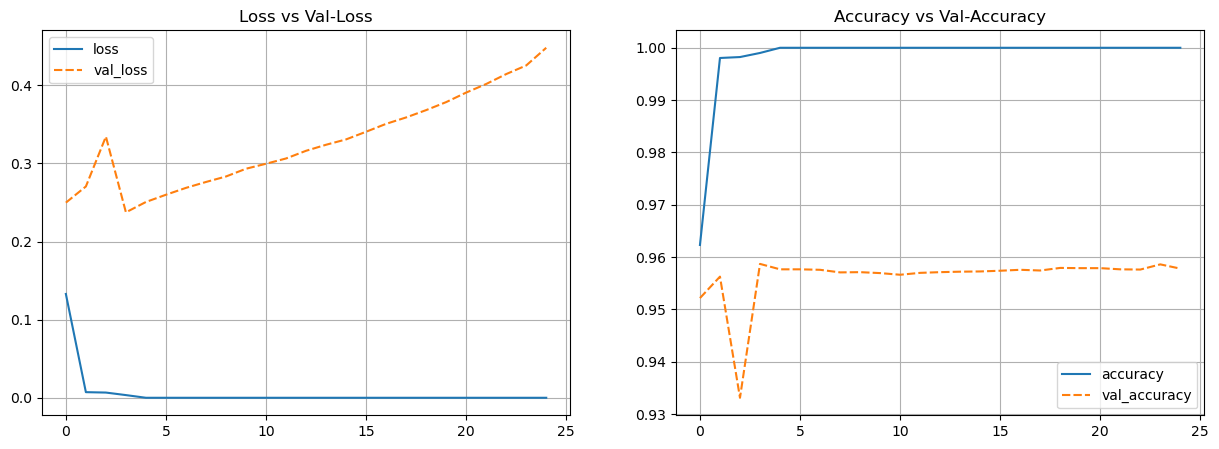

In [68]:
# Plot Training Results
history_2_df= pd.DataFrame(history_2.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_2_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_2_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [69]:
results_train= model_functional.evaluate(train, verbose=0)
print('train_acc', results_train[1])
print('train_loss', results_train[0])

train_acc 1.0
train_loss 2.505900764671054e-10


In [70]:
results_val= model_functional.evaluate(val, verbose=0)
print('val_acc', results_val[1])
print('val_loss', results_val[0])

val_acc 0.9577928185462952
val_loss 0.44801339507102966


Conclusion :
1. Model Performance:

    - Training Accuracy: 1.0 (100%) - indicates the model performed perfectly on the training data, classifying all examples correctly.
    - Training Loss: 2.5059e-10 - this is a very low loss value, indicating the model has learned the training data very well.
    - Validation Accuracy: 0.9578 - this is still a good accuracy, but much lower than the training accuracy, indicating potential for overfitting.
    - Validation Loss: 0.4480 - this is a higher loss value than the training loss, which further indicates overfitting.

2. The model appears to be overfitting the training data. Although it performs perfectly on the training set, its generalization to unseen data (represented by the validation set) is not that good, as shown by the significant drop in accuracy and higher loss on the validation set.

# **F. ANN Improvement**

At this stage, improvements were made to the model by adding a dropout after the hidden layer and setting the learning rate value on the Adam optimizer to 0.001 with the aim of making the optimizer move slowly to avoid passing the local minimum. At this training stage I added a callback which contains Reduce learning rate and Early stopping where the model will stop at the best weight every 5 epochs

## **1. Sequential API Improvement**

### 1.1. Model Definition

In [9]:
# Create Sequential API
model_ann_sequential_improve = tf.keras.models.Sequential()

# Convolutional Layer
model_ann_sequential_improve.add(tf.keras.layers.Conv2D(32, (3,3), strides=(1, 1), padding='valid', activation='relu', input_shape=(50, 50, 3), name='conv-layer1'))
model_ann_sequential_improve.add(tf.keras.layers.MaxPooling2D(2, 2))
model_ann_sequential_improve.add(tf.keras.layers.Conv2D(64, (3,3), strides=(1, 1), padding='valid', activation='relu', name='conv-layer2'))
model_ann_sequential_improve.add(tf.keras.layers.MaxPooling2D(2, 2))

# hidden layer
model_ann_sequential_improve.add(tf.keras.layers.Flatten(name='flatten'))
model_ann_sequential_improve.add(tf.keras.layers.Dropout(0.5))
model_ann_sequential_improve.add(tf.keras.layers.Dense(512, activation='relu', name='hidden-layer1'))
model_ann_sequential_improve.add(tf.keras.layers.Dropout(0.5))
model_ann_sequential_improve.add(tf.keras.layers.Dense(256, activation='relu', name='hidden-layer2'))
model_ann_sequential_improve.add(tf.keras.layers.Dropout(0.5))
model_ann_sequential_improve.add(tf.keras.layers.Dense(128, activation='relu', name='hidden-layer3'))
model_ann_sequential_improve.add(tf.keras.layers.Dropout(0.5))
model_ann_sequential_improve.add(tf.keras.layers.Dense(37, activation='softmax', name='output'))

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Set initial learning rate
model_ann_sequential_improve.compile(loss = 'categorical_crossentropy', 
               optimizer=optimizer, 
               metrics=['accuracy'])

# mencetak ringkasan struktur dan konfigurasi model
model_ann_sequential_improve.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv-layer1 (Conv2D)        (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv-layer2 (Conv2D)        (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)             

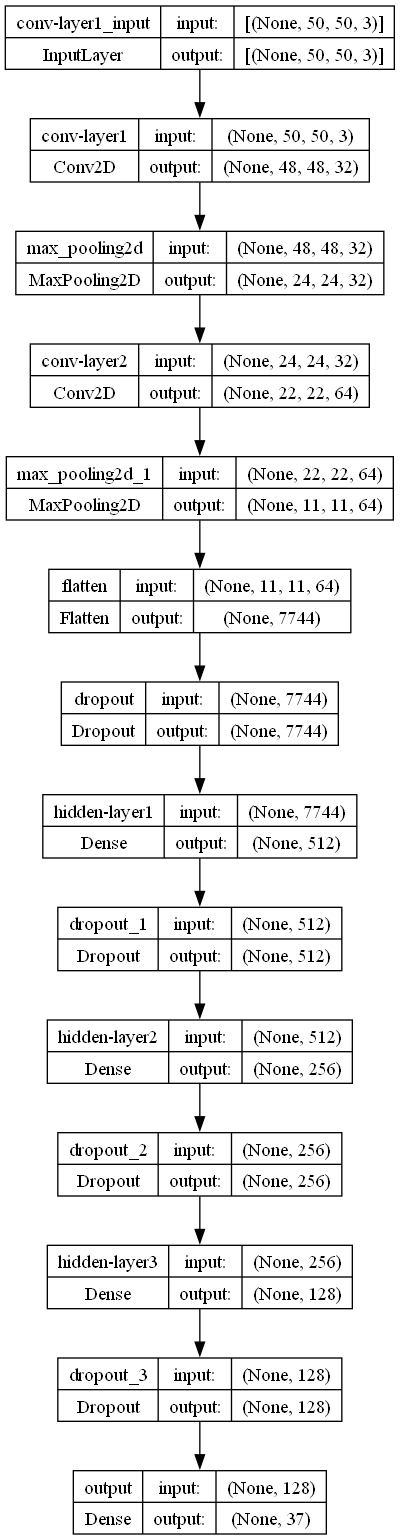

In [10]:
# Plot Layers

tf.keras.utils.plot_model(model_ann_sequential_improve,show_shapes=True)

### 1.2. Model Training

In [11]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)  # Reduce learning rate on plateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)  # Early stopping

# Train the model
history_3 = model_ann_sequential_improve.fit(
    train,
    batch_size=32, 
    validation_data=(val),
    epochs=50, 
    callbacks=[reduce_lr, early_stop],  # Callbacks
)

Epoch 1/50


1041/1041 [==============================] - 178s 169ms/step - loss: 1.0530 - accuracy: 0.6802 - val_loss: 0.1862 - val_accuracy: 0.9477 - lr: 0.0010
Epoch 2/50
1041/1041 [==============================] - 145s 139ms/step - loss: 0.1070 - accuracy: 0.9663 - val_loss: 0.1274 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 3/50
1041/1041 [==============================] - 147s 141ms/step - loss: 0.0640 - accuracy: 0.9809 - val_loss: 0.1671 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 4/50
1041/1041 [==============================] - 136s 130ms/step - loss: 0.0488 - accuracy: 0.9855 - val_loss: 0.1445 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 5/50
1041/1041 [==============================] - 136s 131ms/step - loss: 0.0386 - accuracy: 0.9891 - val_loss: 0.1421 - val_accuracy: 0.9739 - lr: 0.0010
Epoch 6/50
1041/1041 [==============================] - 137s 132ms/step - loss: 0.0381 - accuracy: 0.9894 - val_loss: 0.2299 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 7/50
1041/1041 [==========

### 1.3. Model Evaluation

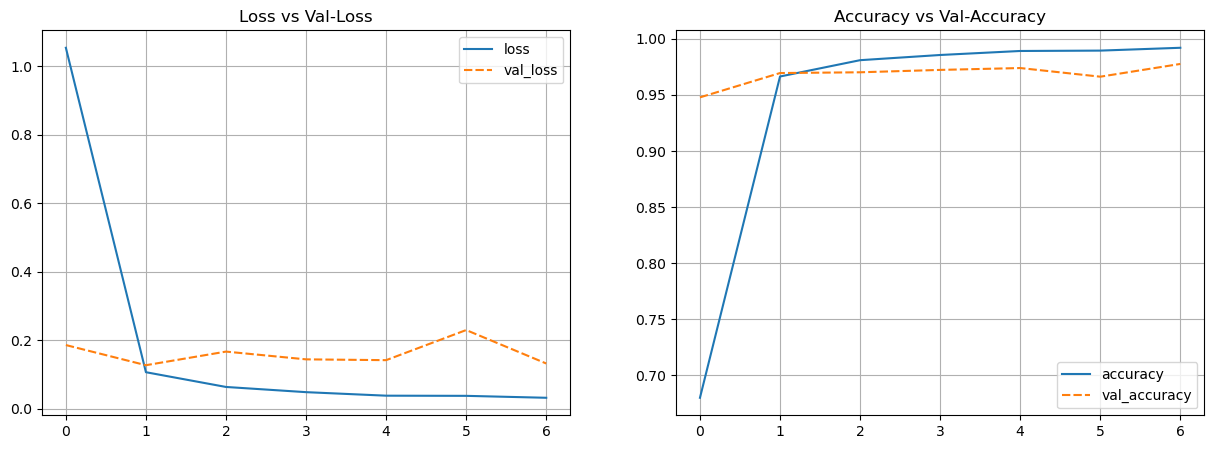

In [12]:
# Plot Training Results
history_3_df= pd.DataFrame(history_3.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_3_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_3_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [13]:
results_train_imp= model_ann_sequential_improve.evaluate(train, verbose=0)
print('train_acc', results_train_imp[1])
print('train_loss', results_train_imp[0])

train_acc 0.9995796084403992
train_loss 0.001311438623815775


In [14]:
results_val_imp= model_ann_sequential_improve.evaluate(val, verbose=0)
print('val_acc', results_val_imp[1])
print('val_loss', results_val_imp[0])

val_acc 0.9694144129753113
val_loss 0.12741602957248688


Conclusion :

1. Model Performance:

    - Training accuracy: 0.9995796084403992 - indicates the model performs very well on the training data.
    - Validation accuracy: 0.9694144129753113 - indicates the model performs well on validation data.
    - Training loss: 0.001311438623815775 - indicates the model has learned the training data very well.
    - Validation loss: 0.12741602957248688 - indicates the model still has room for improvement on validation data.

2. The model has been trained well and shows excellent performance on the training data.
3. The model still needs to be optimized to improve its performance on validation data.

## **2. Functional API Improvement**

### 2.1. Model Definition

In [25]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Model menggunakan Functional API
input_layer = Input(shape=(50, 50, 3), name='input')

# Menambahkan Convolutional Layer
conv_layer1 = Conv2D(32, (3,3), strides=(1, 1), padding='valid', activation='relu')(input_layer)
maxpool_layer1 = MaxPooling2D(2, 2)(conv_layer1)
conv_layer2 = Conv2D(64, (3,3), strides=(1, 1), padding='valid', activation='relu')(maxpool_layer1)
maxpool_layer2 = MaxPooling2D(2, 2)(conv_layer2)

# Layer-layer Dense setelah lapisan konvolusi
hidden_layer1 = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed), name='hidden_layer1')(maxpool_layer2)
dropout1 = Dropout(0.5)(hidden_layer1)
hidden_layer2 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed), name='hidden_layer2')(dropout1)
dropout2 = Dropout(0.5)(hidden_layer2)
hidden_layer3 = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed), name='hidden_layer3')(dropout2)
dropout3 = Dropout(0.5)(hidden_layer3)

# Menggabungkan hasil dari lapisan Dense
concat = Concatenate(name='concat')([hidden_layer1, dropout3])
flatten = Flatten()(concat)

# Output layer
output_layer = Dense(37, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed), name='output')(flatten)

# Membuat model
model_functional_improve = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Set initial learning rate
model_functional_improve.compile(loss = 'categorical_crossentropy', 
               optimizer=optimizer, 
               metrics=['accuracy'])

# mencetak ringkasan struktur dan konfigurasi model
model_functional_improve.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           896       ['input[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 22, 22, 64)           18496     ['max_pooling2d[0][0]']   

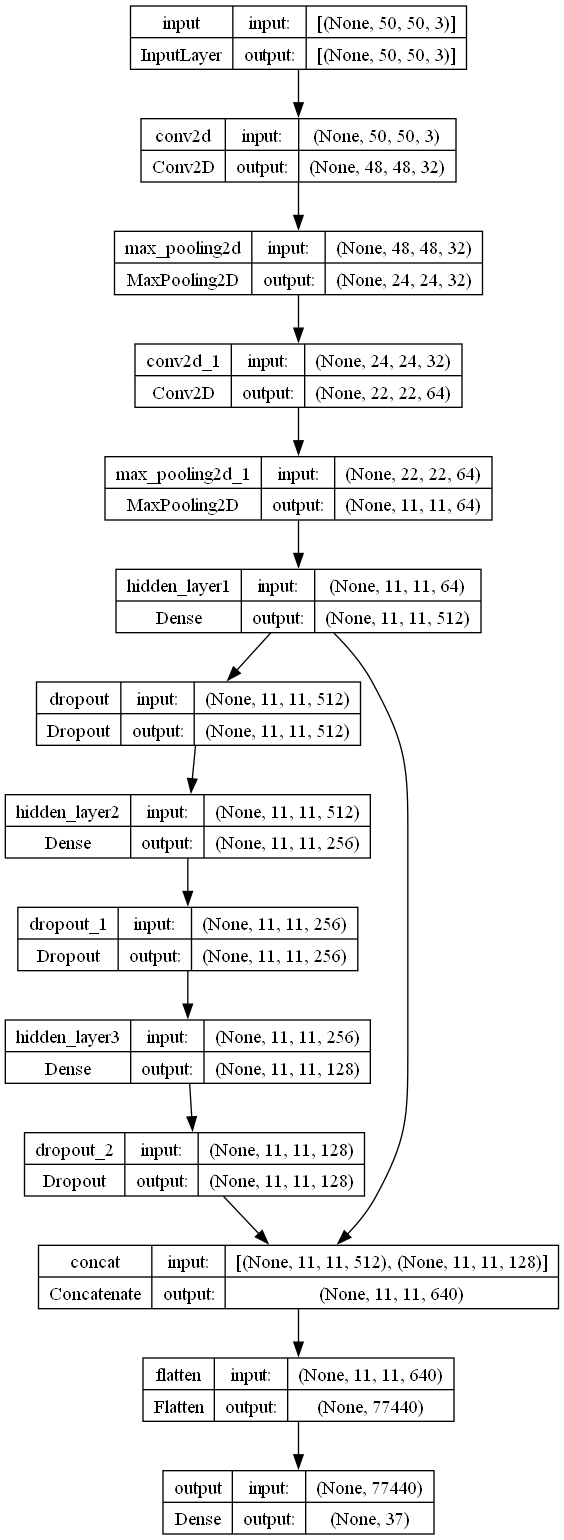

In [26]:
# Plot Layers

tf.keras.utils.plot_model(model_functional_improve,show_shapes=True)

### 2.2. Model Training

In [29]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)  # Reduce learning rate on plateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)  # Early stopping

# Train the model
history_4 = model_functional_improve.fit(
    train,
    batch_size=32, 
    validation_data=(val),
    epochs=50, 
    callbacks=[reduce_lr, early_stop],  # Callbacks
)

Epoch 1/50
1041/1041 [==============================] - 215s 207ms/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.1567 - val_accuracy: 0.9589 - lr: 0.0010
Epoch 2/50
1041/1041 [==============================] - 179s 172ms/step - loss: 1.6190e-04 - accuracy: 1.0000 - val_loss: 0.1650 - val_accuracy: 0.9679 - lr: 0.0010
Epoch 3/50
1041/1041 [==============================] - 170s 164ms/step - loss: 9.2264e-06 - accuracy: 1.0000 - val_loss: 0.1747 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 4/50
1041/1041 [==============================] - 168s 162ms/step - loss: 4.9093e-06 - accuracy: 1.0000 - val_loss: 0.1827 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 5/50
1041/1041 [==============================] - 170s 163ms/step - loss: 2.3763e-06 - accuracy: 1.0000 - val_loss: 0.1891 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 6/50
1041/1041 [==============================] - ETA: 0s - loss: 1.3374e-06 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


### 2.3. Model Evaluation

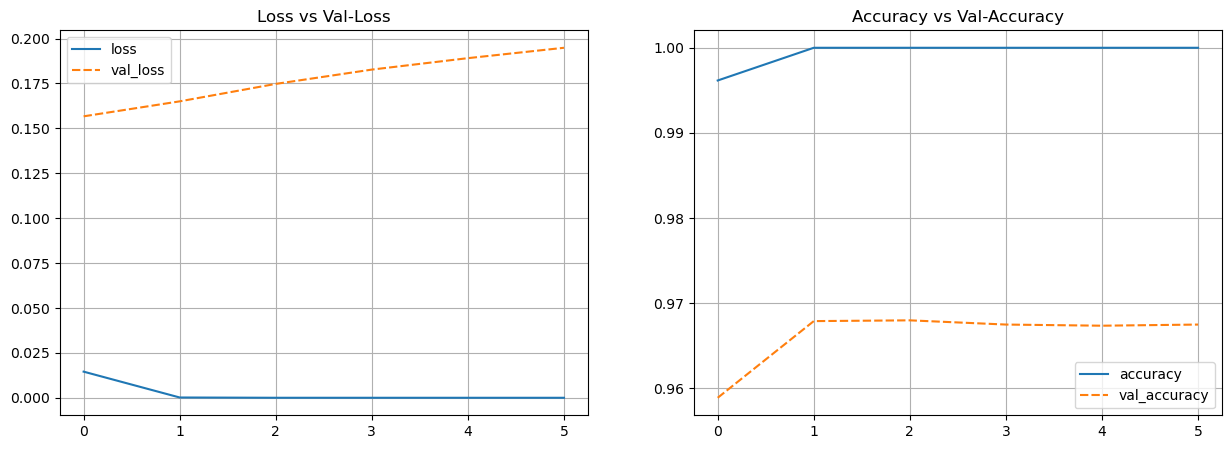

In [30]:
# Plot Training Results
history_4_df= pd.DataFrame(history_4.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_4_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_4_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [32]:
results_train_imp= model_functional_improve.evaluate(train, verbose=0)
print('train_acc', results_train_imp[1])
print('train_loss', results_train_imp[0])

train_acc 0.9996696710586548
train_loss 0.0026248875074088573


In [33]:
results_val_imp= model_functional_improve.evaluate(val, verbose=0)
print('val_acc', results_val_imp[1])
print('val_loss', results_val_imp[0])

val_acc 0.9588738679885864
val_loss 0.15667957067489624


Conclusion :

1. Model Performance:

    - Training accuracy: 0.9997 (almost 100%) - This shows the model performed very well on the training data, classifying almost all examples correctly.
    - Training loss: 0.0026 - This is a very low loss value, indicating the model has learned the training data very well.
    - Validation accuracy: 0.9589 - This is still good accuracy, but slightly lower than training accuracy. This difference suggests a slight potential for overfitting.
    - Validation loss: 0.1567 - This is a higher loss value than training loss, but still relatively low. This slight increase in loss also indicates a slight potential for overfitting.
    
2. Overall, the model appears to have been trained well and shows good performance on both training and validation data. However, there was a slight difference between training and validation accuracy, as well as a slight increase in loss on validation data, indicating a slight potential for overfitting.

# **G. Comparison**

**ANN Sequential :**
- train_acc 0.9986486434936523
- train_loss 0.004921725019812584
- val_acc 0.9456306099891663
- val_loss 0.34463950991630554


**ANN Functional :**
- train_acc 1.0
- train_loss 2.505900764671054e-10
- val_acc 0.9577928185462952
- val_loss 0.44801339507102966

**ANN Sequential Improve:**
- train_acc 0.9995796084403992 
- train_loss 0.001311438623815775
- val_acc 0.9694144129753113
- val_loss 0.12741602957248688

**ANN Functional Improve:**
- train_acc 0.9996696710586548
- train_loss 0.0026248875074088573
- val_acc 0.9588738679885864
- val_loss 0.15667957067489624

**Conclusion :**
Based on the results provided, the best model is **ANN Sequential Improve**. This model shows excellent generalization capabilities, balancing high validation accuracy with much lower validation loss than other models, demonstrating greater robustness and suitability for real-world applications.

# **H. Model Saving**

In [15]:
model_ann_sequential_improve.save('model_ann_sequential_improve.h5')

C:\Users\Muhammad Hafidz Adit.DESKTOP-6IPGJGG\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# **I. Conclusion**

1. EDA Data Analysis:
    - There are 37 classes of sign language movements with even data distribution (1500 data per class).
    - This indicates a balanced dataset without class bias, ideal for model training.

2. Model Comparison:
    - ANN Sequential Improve is the best model with high training & validation accuracy, and low validation loss.
    - This model shows great potential for sign language recognition applications.
    
3. Model Advantages:
    - High accuracy on training and validation data
    - Low validation loss
    - Balance between accuracy and generalization

4. Model Disadvantages:
    - Slight potential for overfitting, although this has been overcome with improvements

5. Improvement Suggestions:
    - Data Augmentation: Increasing the diversity of training data with artificial variations (rotation, flip, noise) to increase model robustness.

6. Business Analysis:
    - Education and training for the deaf

7. Conclusion:
    - The ANN Sequential Improve model shows promising performance for sign language recognition. By applying data augmentation, this model can be optimized to produce applications that benefit the deaf community.